## Object detection - Identify cars in set of images with Facebook detectron


# instalation and libreries

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ylu90qp1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ylu90qp1
  Resolved https://github.com/facebookresearch/detectron2.git to commit d779ea63faa54fe42b9b4c280365eaafccb280d6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
from google.colab.patches import cv2_imshow


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

## Preparing the Dataset
build the list of training and valid dataset names

In [3]:
img_dir = '/content/cars/'
content = os.listdir(img_dir)
print(len(content)) 
content.remove('annotations_sample.json')
print(len(content))

201
200


In [4]:
list_val= []
for i in range (0,int(0.1*len(content))): # divide the dataset to train(90%) and validation(10%)
  a = random.randint(0,len(content))
  b = content[a]
  list_val.append(b)
  content.remove(b)
list_train = content   
print(len(list_val))
print(len(list_train))

20
180


In [5]:
def get_car_images(img_folder, img_list):
    json_file = os.path.join(img_folder, "annotations_sample.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    for idx,img in enumerate(img_list):
        record = {}
        filename = os.path.join(img_folder, img)
        height, width = cv2.imread(filename).shape[:2]        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        for i in range(0, len(imgs_anns['annotations'])):
            if ((img == imgs_anns['annotations'][i]['file_name']) and (imgs_anns['annotations'][i]['category_id']==3)):
              obj = {
                "bbox": imgs_anns['annotations'][i]['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation":imgs_anns['annotations'][i]['segmentation'],
                "category_id": 0,
               }
              objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

###registering data

In [6]:
DatasetCatalog.register("car_train" , lambda: get_car_images(img_dir,list_train))
MetadataCatalog.get("car_train").set(thing_classes=["car"])

DatasetCatalog.register("car_val" , lambda: get_car_images(img_dir,list_val))
MetadataCatalog.get("car_val").set(thing_classes=["car"])

namespace(name='car_val', thing_classes=['car'])

In [7]:

car_metadata = MetadataCatalog.get("car_train")


###Visualizing the Train Dataset

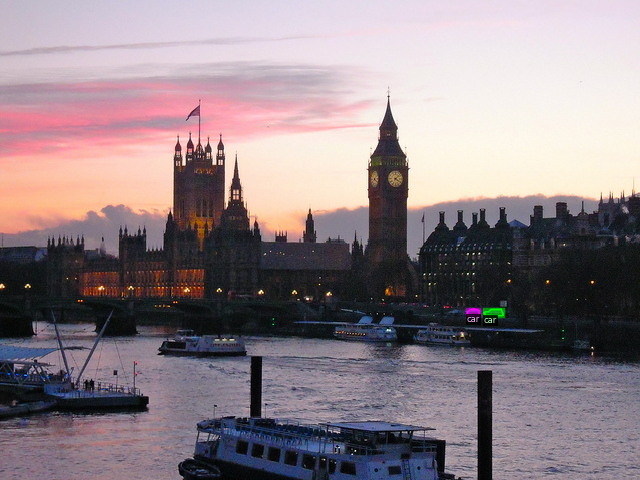

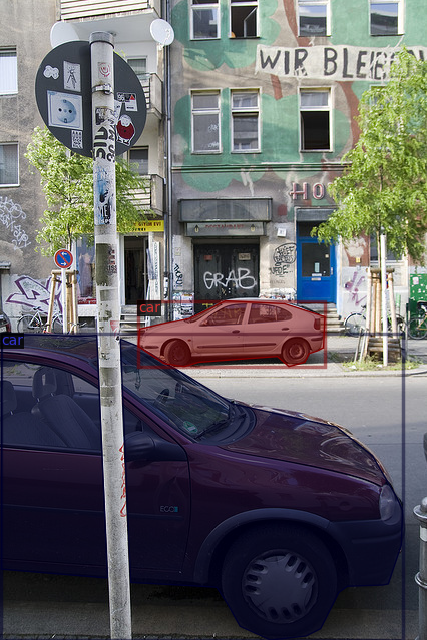

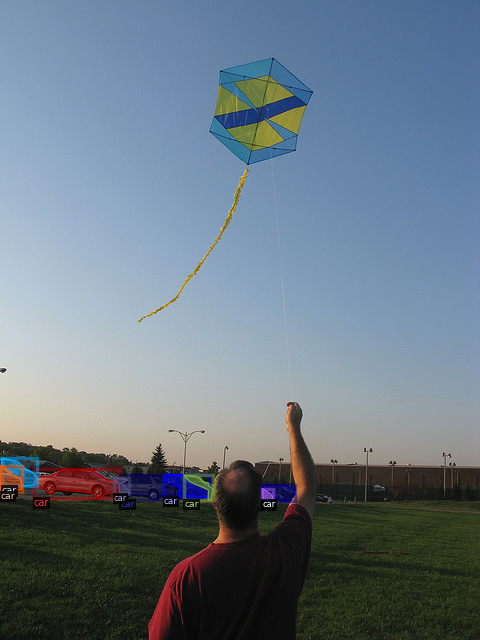

In [8]:
dataset_dicts = DatasetCatalog.get('car_train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Configuring and Training

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 200 
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 500

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/04 12:40:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[04/04 12:40:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


model_final_68b088.pkl: 421MB [00:02, 203MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/04 12:40:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/04 12:41:31 d2.utils.events]:  eta: 0:10:08  iter: 19  total_loss: 1.604  loss_cls: 0.6526  loss_box_reg: 0.9025  loss_rpn_cls: 0.02686  loss_rpn_loc: 0.01696    time: 3.4363  last_time: 3.2816  data_time: 0.0496  last_data_time: 0.0439   lr: 9.5905e-05  max_mem: 10914M
[04/04 12:42:39 d2.utils.events]:  eta: 0:09:01  iter: 39  total_loss: 1.371  loss_cls: 0.4733  loss_box_reg: 0.8816  loss_rpn_cls: 0.02784  loss_rpn_loc: 0.02327    time: 3.4352  last_time: 3.3683  data_time: 0.0320  last_data_time: 0.0375   lr: 0.00019581  max_mem: 10914M
[04/04 12:43:53 d2.utils.events]:  eta: 0:08:05  iter: 59  total_loss: 1.137  loss_cls: 0.324  loss_box_reg: 0.7835  loss_rpn_cls: 0.02284  loss_rpn_loc: 0.01558    time: 3.5288  last_time: 3.6448  data_time: 0.0314  last_data_time: 0.0257   lr: 0.00029571  max_mem: 10914M
[04/04 12:45:05 d2.utils.events]:  eta: 0:07:03  iter: 79  total_loss: 0.9871  loss_cls: 0.2591  loss_box_reg: 0.6998  loss_rpn_cls: 0.02481  loss_rpn_loc: 0.02151    time: 3.5

###Save the trained model and evaluation

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  
predictor = DefaultPredictor(cfg)

[04/04 12:52:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [12]:
from detectron2.data import  build_detection_test_loader

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("car_val", cfg, False, output_dir="/content/output/")
val_loader = build_detection_test_loader(cfg, "car_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/04 12:52:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/04 12:52:40 d2.evaluation.coco_evaluation]: Trying to convert 'car_val' to COCO format ...
[04/04 12:52:40 d2.data.datasets.coco]: Converting annotations of dataset 'car_val' to COCO format ...)
[04/04 12:52:40 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/04 12:52:40 d2.data.datasets.coco]: Conversion finished, #images: 20, #annotations: 68
[04/04 12:52:40 d2.data.datasets.coco]: Caching COCO format annotations at '/content/output/car_val_coco_format.json' ...
[04/04 12:52:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    car     | 68           |
|            |              |
[04/04 12:52:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[04/04 12:52:43 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0017 s/iter. Inference: 0.2588 s/iter. Eval: 0.0003 s/iter. Total: 0.2609 s/iter. ETA=0:00:02
[04/04 12:52:46 d2.evaluation.evaluator]: Total inference time: 0:00:03.999702 (0.266647 s / iter per device, on 1 devices)
[04/04 12:52:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.259379 s / iter per device, on 1 devices)
[04/04 12:52:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/04 12:52:46 d2.evaluation.coco_evaluation]: Saving results to /content/output/coco_instances_results.json
[04/04 12:52:46 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[04/04 12:52:46 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/04 12:52:46 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[04/04 12:52:46 d2.eval

OrderedDict([('bbox',
              {'AP': 56.45819159828359,
               'AP50': 82.53146209200212,
               'AP75': 61.74281646467023,
               'APs': 42.571928798056945,
               'APm': 77.07772467445092,
               'APl': 79.37376237623764})])

### Visualizing the trained model on validation

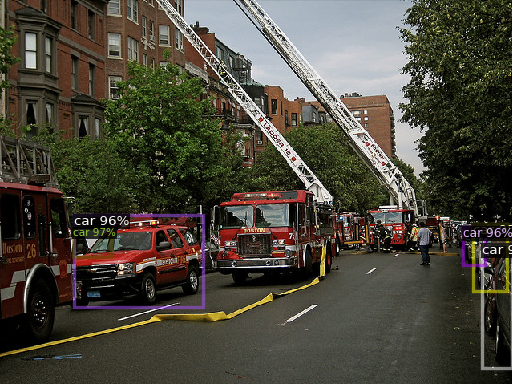

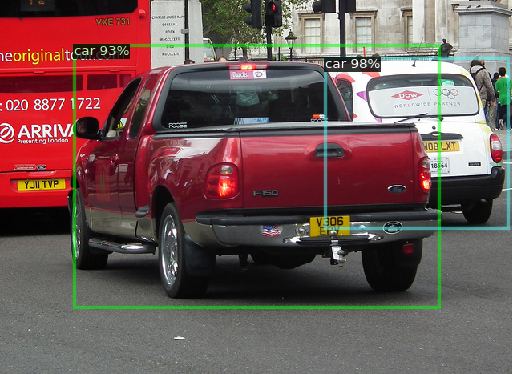

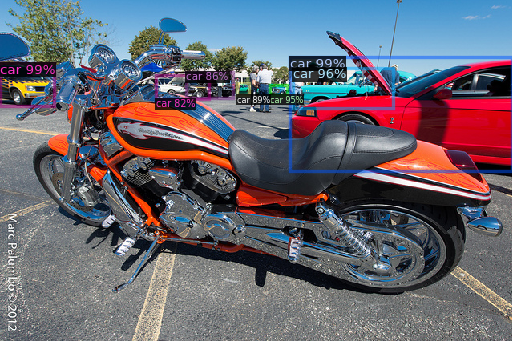

In [13]:
dataset_dicts = DatasetCatalog.get('car_val')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=car_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Get the output for validation dataset

In [57]:
def csv_maker (valid_dataset = 'car_val', img_dir = '/content/cars/' , csv_dir = '/content/out.csv'):
  dataset_dicts = DatasetCatalog.get(valid_dataset)
  out_list = []
  for d in dataset_dicts:    
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      x = outputs["instances"].pred_boxes.tensor
      for i in range(0,len(x)):
        coor = [x[i][m].item() for m in range(0,4)]
        coor2 = [((coor[0]+coor[2])/2),((coor[1]+coor[3])/2),(coor[1]-coor[3]),(coor[2]-coor[0])]
        out_list.append([d["file_name"].removeprefix(img_dir),coor])
  df = pd.DataFrame(out_list)
  df.columns=['image_name','bounding box coordinates']    
  df.to_csv(csv_dir, index=False)  


In [58]:
csv_maker (valid_dataset = 'car_val', img_dir = '/content/cars/' , csv_dir = '/content/out.csv')